In [2]:
%reload_ext autoreload

In [3]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import matplotlib as mpl
# mpl.use('agg')
mpl.rcParams['figure.max_open_warning'] = False
# pgf_with_rc_fonts = {
#     "font.family": "serif",
#     "font.serif": [],                   # use latex default serif font
#     "font.sans-serif": ["DejaVu Sans"], # use a specific sans-serif font
# }
# mpl.rcParams.update(pgf_with_rc_fonts)

# from matplotlib2tikz import save as tikz_save

In [18]:
from quantum_tools.contexts.quantum_caller import *
from quantum_tools.statistics import *
from quantum_tools.examples.symbolic_contexts import *
from quantum_tools.examples.prob_dists import *
from quantum_tools.rmt.unitary_param import *
from quantum_tools.rmt.utils import *
from quantum_tools.utilities import utils
from quantum_tools.statistics.probability import *
from quantum_tools.visualization.transversal_inequalities import *
from quantum_tools.config import *
from quantum_tools.inflation import marginal_equality
from itertools import permutations, product
from operator import itemgetter
import numpy as np
from scipy import optimize
from quantum_tools.visualization.triangle_plot import *
from matplotlib import rc, rcParams
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
rcParams.update({'figure.autolayout': True})

<IPython.core.display.Javascript object>


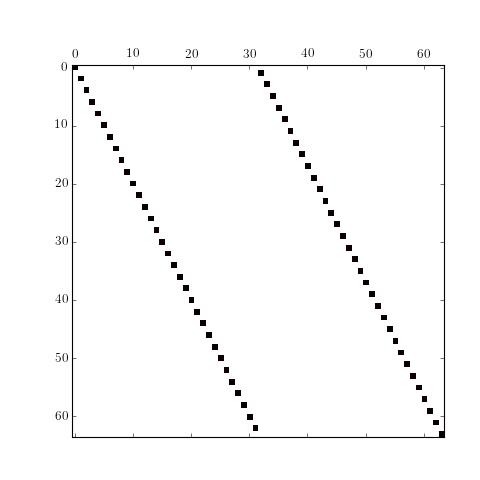

/usr/lib/python3.4/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


In [18]:
# plt.figure()
plt.matshow(utils.get_triangle_permutation(2).real, cmap='hot_r')
# plt.title(r'Network Permutation Matrix $\Omega$')
plt.savefig(r"T:\GitProjects\hardy-fritz-triangle-paper\figures\perm_mtrx.pdf", format='pdf', dpi=1000)

In [55]:
result_backlog = []

def minimize_callback(f):
    logged_results = []
    result_backlog.append(logged_results)
    def _callback(x, *args, **kwargs):
        result = f(x)
#         print(result)
        print(result, end='\r')
        logged_results.append(result)
    return _callback

def stochastic_jump(x, scale_std=0.001):
    norm_x = np.linalg.norm(x)
    delta_x = np.random.normal(0.0, norm_x * scale_std, x.shape)
    return x + delta_x

In [5]:
def CHSH_Target(pds):
    pd1, pd2, pd3, pd4 = pds
    return -(pd1.correlation(('A', 'B')) + pd2.correlation(('A', 'B')) + pd3.correlation(('A', 'B')) - pd4.correlation(('A', 'B')))

In [41]:
rvc = RandomVariableCollection.new(('A', 'B'), (2,2))

def convex_dist(rvc, param):
    param = param.copy()
    param = np.abs(param)
    param /= np.sum(param)
    param = param.reshape(rvc.outcome_space.get_input_base())
    return ProbDist(rvc, param)
    
def convex_seed(rvc):
    return np.random.uniform(0,1,4*len(rvc.outcome_space))

class CHSHConvexityCaller(ParamCaller):
    
    def __init__(self):
        super().__init__(CHSH_Target, [4, 4, 4, 4])
        
    def context(self, param):
        return tuple(convex_dist(rvc, param[self.slots[i]]) for i in range(4))
    
      
class CHSHQuantumCaller(ParamCaller):

    def __init__(self):
        super().__init__(CHSH_Target, [2,2,2,2,15])
        self.m = MeasurementParam(2)
        self.s = StateParam(4, 4)

    def context(self, param):
        sA1, sA2, sB1, sB2, srho = self.slots

        A1 = ProjectiveMeasurement(self.m.gen(param[sA1]))
        A2 = ProjectiveMeasurement(self.m.gen(param[sA2]))
        B1 = ProjectiveMeasurement(self.m.gen(param[sB1]))
        B2 = ProjectiveMeasurement(self.m.gen(param[sB2]))
        
        rho = State(self.s.gen(param[srho]))
        
        A = [A1, A2]
        B = [B1, B2]
        
        pds = []
        for i, j in [(0,0),(0,1),(1,0),(1,1)]:
            qc = QuantumContext(
                random_variables=rvc,
                measurements=(A[i],B[j]),
                states=(rho,),
            )
            pd = QuantumProbDistOptimized(qc)
            pds.append(pd)
        return tuple(pds)

In [64]:
result_backlog = []
for run in range(5):
    print(run)
    q = CHSHQuantumCaller()
    x0 = np.random.uniform(0,1,q.size)
    optimize.minimize(q, x0, tol=0.00001, callback=minimize_callback(q))
result_list_q = [np.array(result_backlog[i]) * -1 for i in range(len(result_backlog))]

0
1
2
3
4


In [58]:
result_backlog = []
for run in range(5):
    print(run)
    f = CHSHConvexityCaller()
    x0 = convex_seed(rvc)
    optimize.minimize(f, x0, tol=0.00001, callback=minimize_callback(f))
result_list_c = [np.array(result_backlog[i]) * -1 for i in range(len(result_backlog))]

0
1
2
3
4


In [62]:
trim_result(result_list_c, 4)

(32,
 [array([ 1.93344,  2.43179,  2.85317,  2.8618 ,  2.93501,  3.40034,  3.68604,  3.69593,  3.75086,  3.77811,  3.85553,
          3.85772,  3.86134,  3.8878 ,  3.91321,  3.93979,  3.959  ,  3.96456,  3.96851,  3.98301,  3.9901 ,  3.99196,
          3.99403,  3.99679,  3.9972 ,  3.99791,  3.99796,  3.99797,  3.99808,  3.99826,  3.99831,  3.99841]),
  array([ 0.35012,  1.22599,  1.82655,  2.22294,  2.51618,  2.72703,  2.89785,  2.96298,  3.07948,  3.15344,  3.2083 ,
          3.26427,  3.74535,  3.8911 ,  3.89226,  3.8943 ,  3.93274,  3.9477 ,  3.95369,  3.98026,  3.98253,  3.98532,
          3.98866,  3.99487,  3.99497,  3.99635,  3.99784,  3.99885,  3.99908,  3.99926,  3.99943,  3.99954]),
  array([ 1.742  ,  2.7419 ,  2.74596,  3.26728,  3.35219,  3.61103,  3.67802,  3.70403,  3.71039,  3.71833,  3.80683,
          3.83956,  3.85569,  3.85607,  3.87058,  3.89308,  3.93229,  3.98584,  3.98584,  3.99447,  3.99649,  3.9969 ,
          3.997  ,  3.99711,  3.998  ,  3.99945,  3.99951, 

In [66]:
def trim_result(result_list, val):
    max_step = 0
    for i in range(len(result_list)):
        j = 0
        while j < len(result_list[i]):
            if (val - result_list[i][j]) < 0.001:
                if j > max_step:
                    max_step = j
                break
            j += 1
    return (max_step-1, [rl[0:max_step] for rl in result_list])

<IPython.core.display.Javascript object>


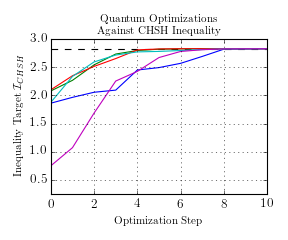

In [85]:
max_step, result_list = trim_result(result_list_q, 2*np.sqrt(2))
plt.figure(figsize=(3.6, 3.0))
plt.xlabel(r'Optimization Step', fontsize=10)
plt.ylabel(r'Inequality Target $\mathcal{I}_{\text{CHSH}}$', fontsize=10)
plt.title('Quantum Optimizations \n Against CHSH Inequality', fontsize=10)
min_h = min(result_list[i][0] for i in range(len(result_list))) - 0.5
max_h = 3.0
plt.axhline(2*np.sqrt(2), linestyle='--', color='black')
for i in range(len(result_list)):
    y = result_list[i]
    plt.plot(np.arange(len(y)), y)
plt.axis([0, max_step, min_h, max_h])
# plt.yticks(sorted(list(plt.yticks()[0]) + [2*np.sqrt(2)]))
# plt.gca().set_yticklabels(["{:.1}".format(x) for x in np.arange(min_h, max_h, 1/2)])
plt.grid(True)
plt.savefig(r"T:\GitProjects\hardy-fritz-triangle-paper\figures\CHSH_quantum.pdf", format='pdf', dpi=1000, bbox='tight')
plt.show()

<IPython.core.display.Javascript object>


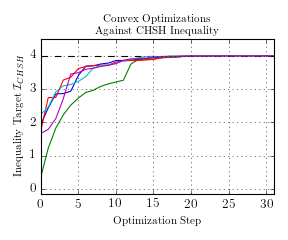

In [70]:
max_step, result_list = trim_result(result_list_c, 4)
plt.figure(figsize=(3.6, 3.0))
plt.xlabel(r'Optimization Step', fontsize=10)
plt.ylabel(r'Inequality Target $\mathcal{I}_{\text{CHSH}}$', fontsize=10)
plt.title('Convex Optimizations \n Against CHSH Inequality', fontsize=10)
min_h = min(result_list[i][0] for i in range(len(result_list))) - 0.5
max_h = 4.5
plt.axhline(4, linestyle='--', color='black')
for i in range(len(result_list)):
    y = result_list[i]
    plt.plot(np.arange(len(y)), y)
plt.axis([0, max_step, min_h, max_h])
plt.grid(True)
plt.savefig(r"T:\GitProjects\hardy-fritz-triangle-paper\figures\CHSH_convex.pdf", format='pdf', dpi=1000, bbox='tight')
plt.show()

In [1]:
gen = ((3, 2, 1, 0, 7, 6, 5, 4, 11, 10, 9, 8),
 (0, 2, 1, 3, 8, 10, 9, 11, 4, 6, 5, 7),
 (8, 9, 10, 11, 0, 1, 2, 3, 4, 5, 6, 7),
 (0, 1, 2, 3, 5, 4, 7, 6, 10, 11, 8, 9))

In [26]:
labels = ["{}_{}".format(letter, number) for letter, number in product(('A', 'B', 'C'), range(1, 5))]

slist = []
for g in gen:
    print(r'\begin{aligned}[c]')
    for x, y in zip(labels, itemgetter(*g)(labels)):
        print(r"{} &\to {} \\".format(x,y), end='')
    print()
    print(r'\end{aligned}')
    print(r'\quad')

\begin{aligned}[c]
A_1 &\to A_4 \\A_2 &\to A_3 \\A_3 &\to A_2 \\A_4 &\to A_1 \\B_1 &\to B_4 \\B_2 &\to B_3 \\B_3 &\to B_2 \\B_4 &\to B_1 \\C_1 &\to C_4 \\C_2 &\to C_3 \\C_3 &\to C_2 \\C_4 &\to C_1 \\
\end{aligned}
\quad
\begin{aligned}[c]
A_1 &\to A_1 \\A_2 &\to A_3 \\A_3 &\to A_2 \\A_4 &\to A_4 \\B_1 &\to C_1 \\B_2 &\to C_3 \\B_3 &\to C_2 \\B_4 &\to C_4 \\C_1 &\to B_1 \\C_2 &\to B_3 \\C_3 &\to B_2 \\C_4 &\to B_4 \\
\end{aligned}
\quad
\begin{aligned}[c]
A_1 &\to C_1 \\A_2 &\to C_2 \\A_3 &\to C_3 \\A_4 &\to C_4 \\B_1 &\to A_1 \\B_2 &\to A_2 \\B_3 &\to A_3 \\B_4 &\to A_4 \\C_1 &\to B_1 \\C_2 &\to B_2 \\C_3 &\to B_3 \\C_4 &\to B_4 \\
\end{aligned}
\quad
\begin{aligned}[c]
A_1 &\to A_1 \\A_2 &\to A_2 \\A_3 &\to A_3 \\A_4 &\to A_4 \\B_1 &\to B_2 \\B_2 &\to B_1 \\B_3 &\to B_4 \\B_4 &\to B_3 \\C_1 &\to C_3 \\C_2 &\to C_4 \\C_3 &\to C_1 \\C_4 &\to C_2 \\
\end{aligned}
\quad


In [20]:
itemgetter(*gen[1])(labels)

('A_1',
 'A_3',
 'A_2',
 'A_4',
 'C_1',
 'C_3',
 'C_2',
 'C_4',
 'B_1',
 'B_3',
 'B_2',
 'B_4')